In [1]:
# We will be using the matplotlib GUI to input points,
# so the following line ensures a non-iPython backend.
%matplotlib 

import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import utils
import cv2 as cv

%load_ext autoreload
%autoreload 2

Using matplotlib backend: MacOSX


# Begin Q3

## Manually defining correspondences 

The following cells will open the matplotlib GUI for you to select corresponding points on the image. You can run these as many times as you like, if you're not satisfied with the points you selected.

Note that the points you select in image 1 and image 2 should:

1. Correspond to the same object(s) in the images
2. Be selected in the _same order_


In [1]:
%matplotlib 

import matplotlib.pyplot as plt
# This cell will load and display the first image.
# Use the GUI to select four points, which will appear as red crosses on the image.
# Close the GUI when you're done.

# If this cell gives you an error re: the matplotlib backend, 
# rerun the first cell.

im1 = io.imread('example_images/uttower1.jpg', as_gray=True)
plt.imshow(im1, cmap='gray')
points1 = plt.ginput(n=4)

# If the GUI is giving you trouble,
# comment out the above line,
# and uncomment the below line.
# points1 = np.load('points1.npy')

# The points will be stored in array points1
# ginput returns points in (x,y), but images are stored in row-major order,
# so we flip the coordinates.

points1 = np.array([list(p)[::-1] for p in points1])

Using matplotlib backend: MacOSX


NameError: name 'io' is not defined

In [3]:
# This cell will load and display the second image.
# Use the GUI to select four points, which will appear as red crosses on the image.
# NOTE: These points should correspond to the points selected in im1.
# Close the GUI when you're done.

im2 = io.imread('example_images/uttower2.jpg', as_gray=True)
plt.imshow(im2, cmap='gray')
points2 = plt.ginput(n=4)

# If the GUI is giving you trouble,
# comment out the above line,
# and uncomment the below line.
# points2 = np.load('points2.npy')

# The points will be stored in array points1
# ginput returns points in (x,y), but images are stored in row-major order,
# so we flip the coordinates.

points2 = np.array([list(p)[::-1] for p in points2])

## Computing Homographies

Fill out the `fit_affine_matrix` function in `panorama.py`, then run the following cells.

In [2]:
from panorama import fit_affine_matrix

# Sanity check for fit_affine_matrix

# Test inputs
a = np.array([[0.5, 0.1], [0.4, 0.2], [0.8, 0.2]])
b = np.array([[0.3, -0.2], [-0.4, -0.9], [0.1, 0.1]])

H = fit_affine_matrix(b, a)

# Target output
sol = np.array(
    [[1.25, 2.5, 0.0],
     [-5.75, -4.5, 0.0],
     [0.25, -1.0, 1.0]]
)

error = np.sum((H - sol) ** 2)

if error < 1e-20:
    print('Implementation correct!')
else:
    print('There is something wrong.')

[[ 1.25000000e+00  2.50000000e+00 -6.66852719e-16]
 [-5.75000000e+00 -4.50000000e+00 -4.38434510e-16]
 [ 2.50000000e-01 -1.00000000e+00  1.00000000e+00]]
Implementation correct!


After completing `fit_affine_matrix`, run the next two cells to warp the images and merge them into a panorama.

(4, 2) (4, 2)
[[ 1.02149758e+00  7.56374121e-02  2.90637318e-15]
 [-6.30967989e-02  1.05842360e+00 -2.57350937e-15]
 [ 2.68365927e+01  2.38427346e+02  1.00000000e+00]]
Output shape: [458 921]
Offset: [-11.9679386   0.       ]


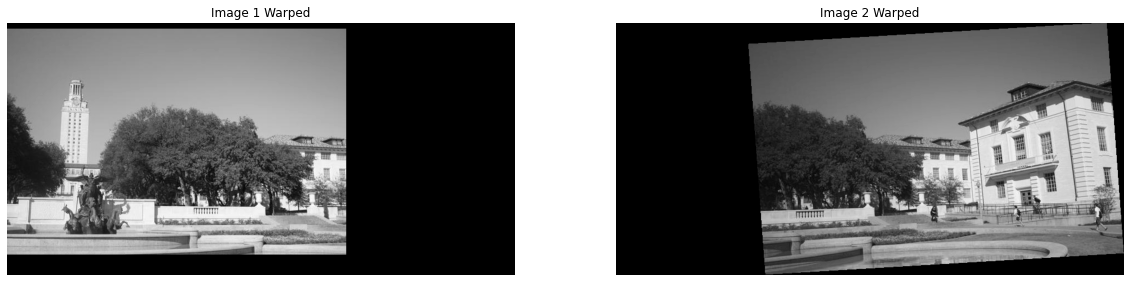

In [5]:
# We can switch back to inline matplotlib now.
%matplotlib inline

from panorama import get_output_space, warp_image

print(points1.shape, points2.shape)
# Compute the affine transform between the two images.
H = fit_affine_matrix(points1, points2)

# get_output_space is a helper function written for you.
# It generates a "canvas" output space to perform the image warp.

output_shape, offset = get_output_space(im1, [im2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)


# Warp images into output sapce
img1_warped = warp_image(im1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(im2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

plt.figure(figsize=(20,10))
# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped, cmap='gray')
plt.title('Image 1 Warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped, cmap='gray')
plt.title('Image 2 Warped')
plt.axis('off')

plt.show()

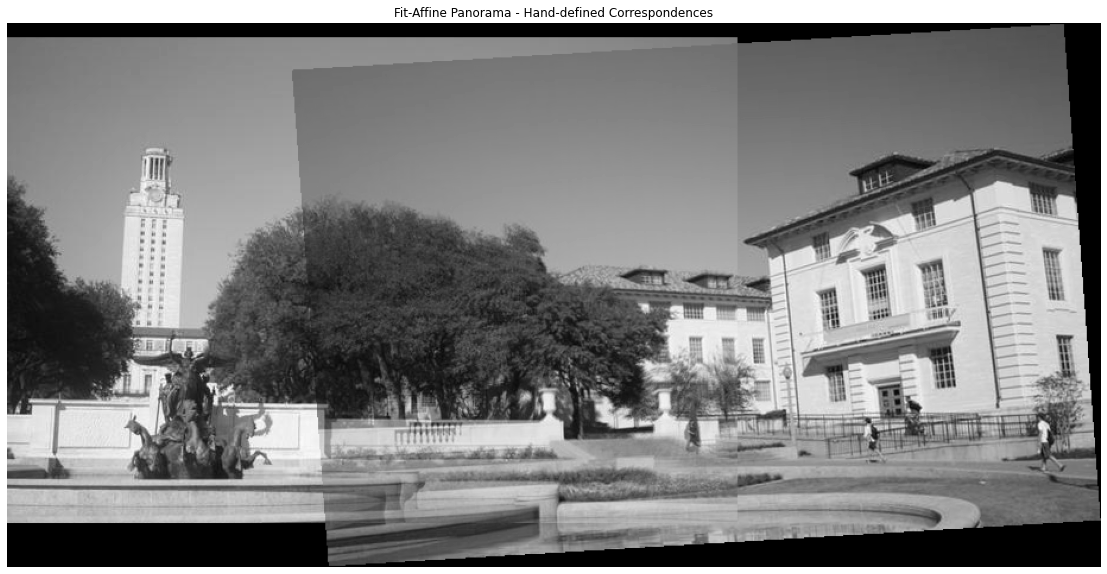

In [6]:
# Merge the two images
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

plt.figure(figsize=(20,10))
plt.imshow(normalized, cmap='gray')
plt.axis('off')
plt.title('Fit-Affine Panorama - Hand-defined Correspondences')
plt.show()

# End Q3

Nice work! 

However, as you may have noticed, computing a homography with only four correspondences is unstable and prone to error. Hand-selecting correspondences is not only tedious, it can cause undesirable results if you are even just a few pixels off. To that end, we've provided an implementation of Harris corner detection in order to automatically select keypoints, as well as a method to describe and match the detected keypoints. 

## Harris Corner Detector

In [2]:
img = cv.imread('example_images/sudoku.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
plt.imshow(gray, cmap='gray')
plt.show()

In [3]:
from panorama import harris_corners, corner_peaks

# Run the function to get Harris corners
# response = cv.cornerHarris(gray,3,3,0.04)
response = harris_corners(gray)

# Run a thresholding function to get the stronger responses
corners = corner_peaks(response, threshold_rel=0.01)

# Display detected corners
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.scatter(corners[:,1], corners[:,0], marker='x')
plt.axis('off')
plt.title('Detected Corners')
plt.show()

In [4]:
from panorama import harris_corners

img1 = cv.imread('example_images/uttower1.jpg')
img2 = cv.imread('example_images/uttower2.jpg')

img1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

print("Keypoints 1 shape = ", keypoints1.shape)
print("Keypoints 2 shape = ", keypoints2.shape)

# Display detected keypoints
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()

Keypoints 1 shape =  (400, 2)
Keypoints 2 shape =  (633, 2)


In [5]:
from panorama import simple_descriptor, match_descriptors, describe_keypoints
from utils import plot_matches

# Set seed to compare output against solution
# np.random.seed(131)

patch_size = 5
    
# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

print("Desc1 shape = ", desc1.shape)
print("Desc2 shape = ", desc2.shape)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)
# print(matches)
# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plt.title('Matched Simple Descriptor')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()

Desc1 shape =  (400, 25)
Desc2 shape =  (633, 25)


(42, 2) (42, 2)
[[ 1.08932358e+00 -3.91438129e-01  6.44657182e-15]
 [-6.73179703e-02  1.96829867e-01 -8.04465839e-15]
 [ 7.31538465e+00  5.24486107e+02  1.00000000e+00]]
Output shape: [489 646]
Offset: [-34.08516709   0.        ]


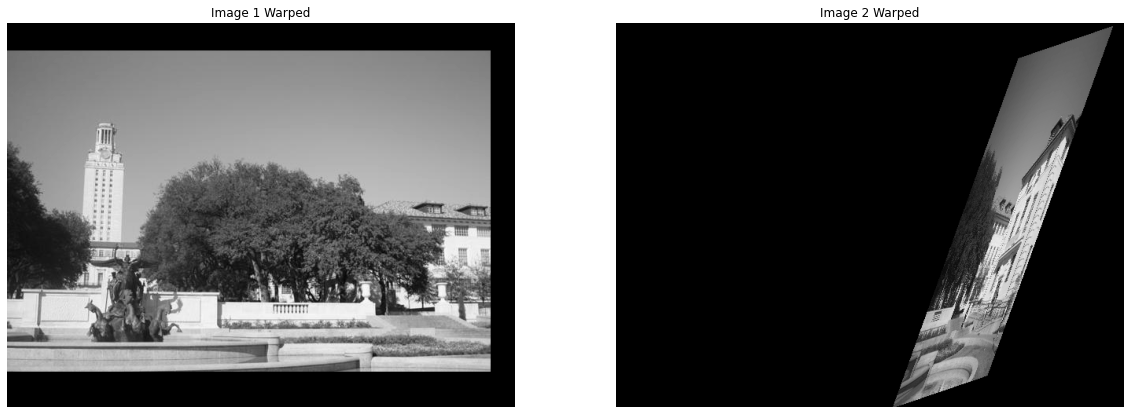

In [6]:
%matplotlib inline

from panorama import fit_affine_matrix, get_output_space, warp_image

matches1 = keypoints1[matches[:,0]]
matches2 = keypoints2[matches[:,1]]
print(matches1.shape, matches2.shape)

# Compute the affine transform between the two images.
H_auto = fit_affine_matrix(matches1, matches2)

# get_output_space is a helper function written for you.
# It generates a "canvas" output space to perform the image warp.

output_shape, offset = get_output_space(img1, [img2], [H_auto])
print("Output shape:", output_shape)
print("Offset:", offset)


# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H_auto, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

plt.figure(figsize=(20,10))
# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped, cmap='gray')
plt.title('Image 1 Warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped, cmap='gray')
plt.title('Image 2 Warped')
plt.axis('off')

plt.show()

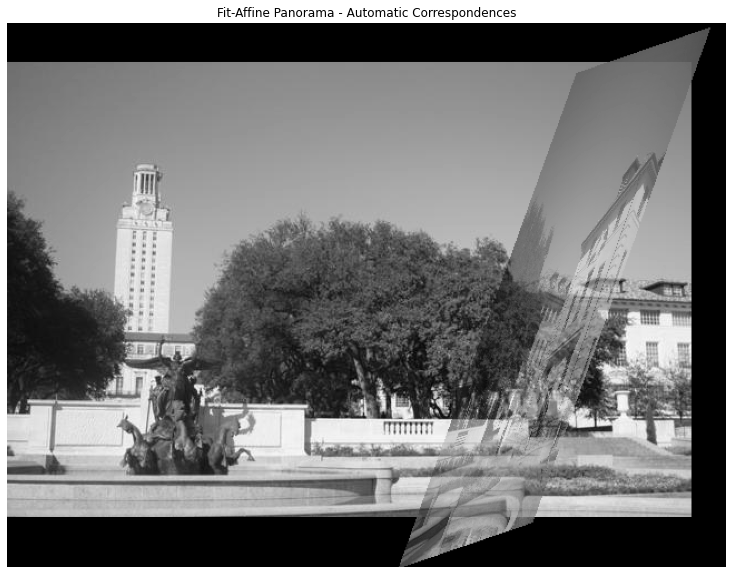

In [7]:
# Merge the two images
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

plt.figure(figsize=(20,10))
plt.imshow(normalized, cmap='gray')
plt.axis('off')
plt.title('Fit-Affine Panorama - Automatic Correspondences')
plt.show()

# Begin Q4

Rather than directly feeding all our keypoint matches into fit_affine_matrix function, we can instead use RANSAC ("RANdom SAmple Consensus") to select only "inliers" to use for computing the transformation matrix.

The steps of RANSAC are:

1. Select random set of matches
2. Compute affine transformation matrix
3. Find inliers using the given threshold
4. Repeat and keep the largest set of inliers
5. Re-compute least-squares estimate on all of the inliers. In this case, use Euclidean distance between matched points as a measure of inliers vs outliers.

Implement `ransac` in `panorama.py`, run through the following code to get a panorama. You can see the difference from the result we get without RANSAC.

Robust matches shape =  (15, 2)
H = 
 [[ 1.01052558e+00  8.08433549e-02  0.00000000e+00]
 [-2.69357857e-02  1.01363225e+00  0.00000000e+00]
 [ 2.21472484e+01  2.46358367e+02  1.00000000e+00]]


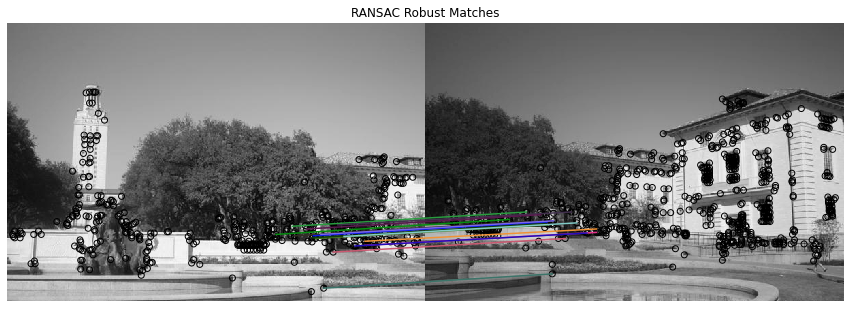

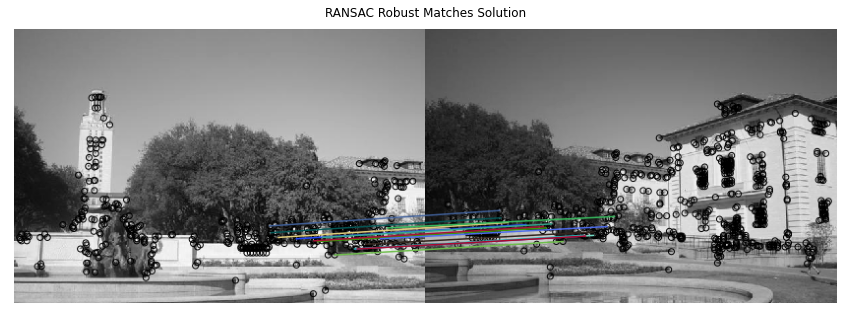

In [23]:
from panorama import ransac

# Set seed to compare output against solution image
np.random.seed(131)

H, robust_matches = ransac(keypoints1, keypoints2, matches, n_iters=200, threshold=1)
print("Robust matches shape = ", robust_matches.shape)
print("H = \n", H)

# Visualize robust matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.title('RANSAC Robust Matches')
plt.show()

plt.figure(figsize=(15,12))
plt.imshow(io.imread('solution_ransac.png'))
plt.axis('off')
plt.title('RANSAC Robust Matches Solution')
plt.show()

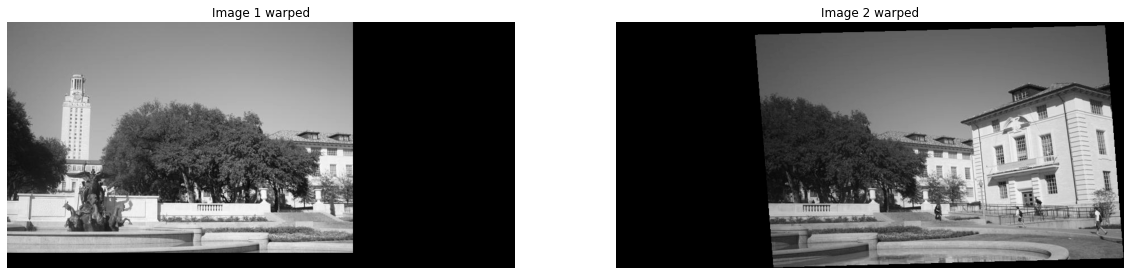

In [24]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img1_warped, cmap='gray')
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped, cmap='gray')
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

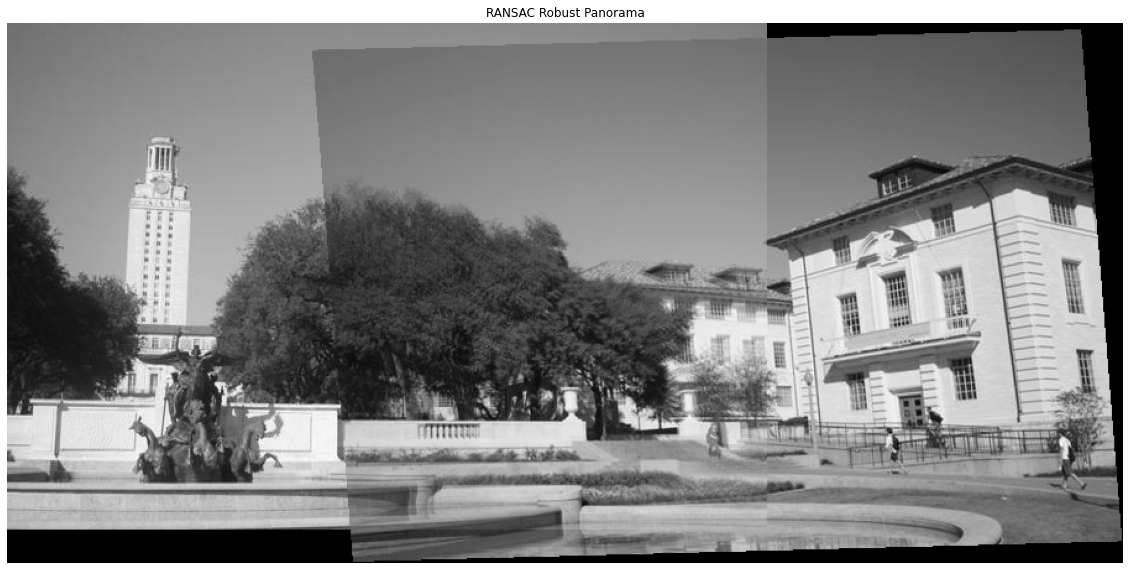

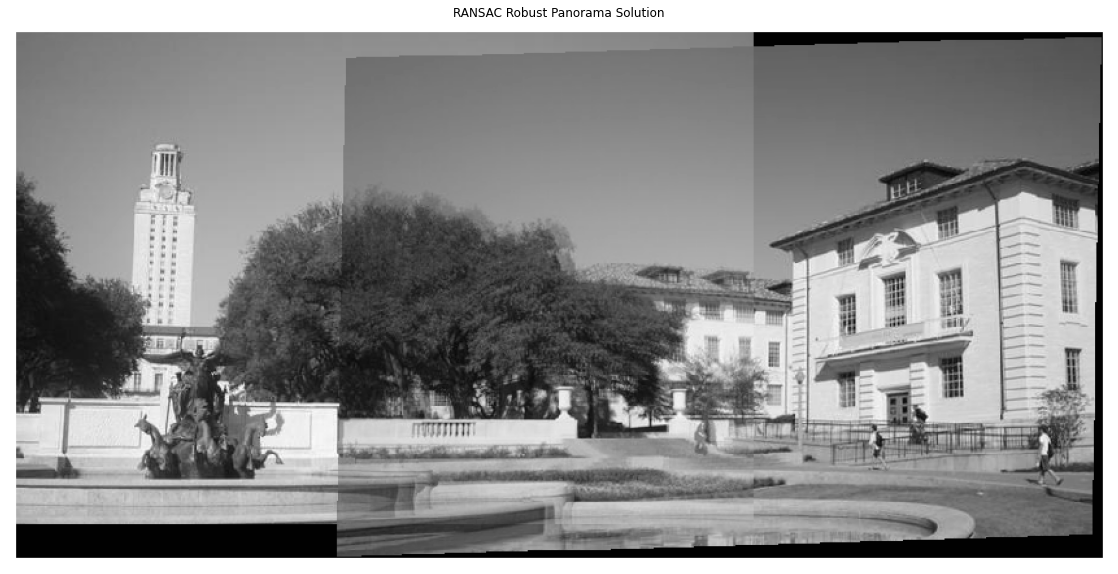

In [25]:

# Merge the two images
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

plt.figure(figsize=(20,10))
plt.imshow(normalized, cmap='gray')
plt.axis('off')
plt.title('RANSAC Robust Panorama')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(io.imread('solution_ransac_panorama.png'))
plt.axis('off')
plt.title('RANSAC Robust Panorama Solution')
plt.show()

# End Q4

# Begin Q5

## Linear Blending

EC1 keypoints1 shape =  (400, 2)
EC1 keypoints2 shape =  (633, 2)
EC1 desc1 shape =  (400, 25)
EC1 desc2 shape =  (633, 25)
Robust matches shape =  (21, 2)
H = 
 [[ 1.06486427e+00  2.59925189e-01  3.91925395e-15]
 [-9.92071823e-02  8.60323964e-02 -4.50448503e-15]
 [ 1.97266193e+01  3.73837466e+02  1.00000000e+00]]
Output shape: [498 615]
Offset: [-41.28579782   0.        ]


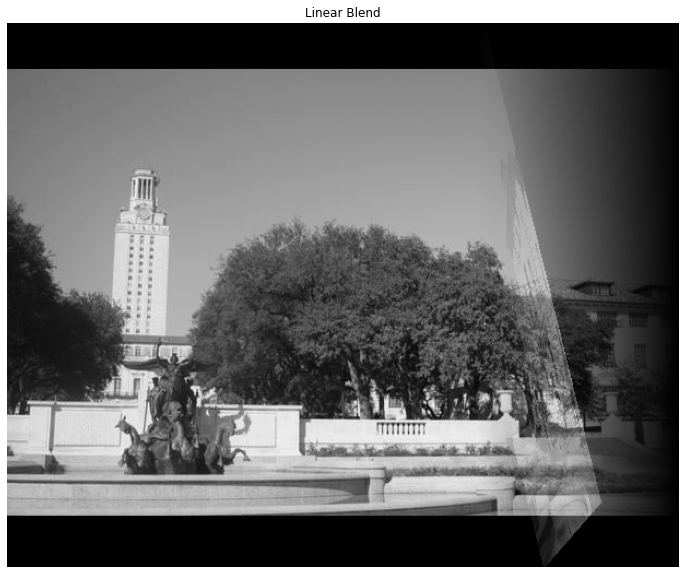

In [144]:
from panorama import linear_blend

img1 = cv.imread('example_images/uttower1.jpg')
img2 = cv.imread('example_images/uttower2.jpg')

img1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)

# Set seed to compare output against solution
np.random.seed(131)

# Detect keypoints in both images
ec1_keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                              threshold_rel=0.05,
                              exclude_border=8)
ec1_keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                              threshold_rel=0.05,
                              exclude_border=8)

print("EC1 keypoints1 shape = ", ec1_keypoints1.shape)
print("EC1 keypoints2 shape = ", ec1_keypoints2.shape)

# Extract features from the corners
ec1_desc1 = describe_keypoints(img1, ec1_keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=5) # Previously had patch_size=16
ec1_desc2 = describe_keypoints(img2, ec1_keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=5) # Previously had patch_size=16

print("EC1 desc1 shape = ", ec1_desc1.shape)
print("EC1 desc2 shape = ", ec1_desc2.shape)

# Match descriptors in image1 to those in image2
ec1_matches = match_descriptors(ec1_desc1, ec1_desc2, 0.7)

H, robust_matches = ransac(ec1_keypoints1, ec1_keypoints2, ec1_matches, threshold=1)
print("Robust matches shape = ", robust_matches.shape)
print("H = \n", H)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Merge the warped images using linear blending scheme
merged = linear_blend(img1_warped, img2_warped)

plt.figure(figsize=(20,10))
plt.imshow(merged, cmap='gray')
plt.axis('off')
plt.title('Linear Blend')
plt.show()

# End Q5